# 导入数据，预处理

In [1]:
import os, codecs
import pandas as pd
import numpy as np
import geopandas as gpd 
import transbigdata as tbd
import warnings


PATH = '/Users/jerseylu/Downloads/bike-sharing/DCIC2021/'

# 共享单车轨迹数据
df_track = pd.concat([
    pd.read_csv(PATH + 'gxdc_gj20201221.csv'),
    pd.read_csv(PATH + 'gxdc_gj20201222.csv'),
    pd.read_csv(PATH + 'gxdc_gj20201223.csv'), # rainy day
    pd.read_csv(PATH + 'gxdc_gj20201224.csv'),
    pd.read_csv(PATH + 'gxdc_gj20201225.csv')

])

# 按照单车ID和时间进行排序
df_track = df_track.sort_values(['BICYCLE_ID', 'LOCATING_TIME'])

In [2]:
def df_fence_format(s):
    s = s.replace('[', '').replace(']', '').split(',')
    s = np.array(s).astype(float).reshape(5, -1)
    return s

# 共享单车停车点位（电子围栏）数据
df_fence = pd.read_csv(PATH + 'gxdc_tcd.csv')
df_fence['FENCE_LOC'] = df_fence['FENCE_LOC'].apply(df_fence_format)

In [3]:
# 共享单车订单数据
df_order = pd.read_csv(PATH + 'gxdc_dd.csv')
df_order = df_order.sort_values(['BICYCLE_ID', 'UPDATE_TIME'])

In [4]:
# 识别单车出行OD
df_order = df_order[['BICYCLE_ID', 'UPDATE_TIME', 'LONGITUDE', 'LATITUDE', 'LOCK_STATUS']]

move_data,stop_data = tbd.bikedata_to_od(df_order,
                   col = ['BICYCLE_ID','UPDATE_TIME','LONGITUDE','LATITUDE','LOCK_STATUS'])

# 删除直线距离小于100米与大于10千米的出行

#计算骑行直线距离
move_data['distance'] = tbd.getdistance(move_data['slon'], move_data['slat'],
                                        move_data['elon'], move_data['elat'])
#清洗骑行数据，删除过长与过短的出行
move_data = move_data[(move_data['distance'] > 100)
                      & (move_data['distance'] < 10000)]

In [5]:
# 地铁站点数据 GCJ02坐标，需要转换成WGS84
subway_xm = pd.read_csv(
    r'/Users/jerseylu/Downloads/bike-sharing/cache/subway_xm.csv',
    header=None,
    names=['station', 'line', 'Lng', 'Lat'])

subway_xm = subway_xm[subway_xm['line'] != '3号线']

# Define a function to apply the transformation
def transform_coordinates(row):
    transformed_lng, transformed_lat = tbd.gcj02towgs84(row['Lng'], row['Lat'])
    return pd.Series([transformed_lng, transformed_lat])

# Apply the transformation function to each row and assign the results to new columns
subway_xm[['Lng', 'Lat']] = subway_xm.apply(transform_coordinates, axis=1)


In [6]:
# 公交站点数据 GCJ02坐标，需要转换成WGS84
bus_xm = pd.read_csv(
    r'/Users/jerseylu/Downloads/bike-sharing/cache/bus_xm.csv',
    header=None,
    names=['number', 'type', 'name', 'Lng', 'Lat'])

# Convert 'Lng' and 'Lat' values to float
bus_xm['Lng'] = pd.to_numeric(bus_xm['Lng'], errors='coerce')
bus_xm['Lat'] = pd.to_numeric(bus_xm['Lat'], errors='coerce')

# Drop rows with NaN values in either 'Lng' or 'Lat'
bus_xm = bus_xm.dropna(subset=['Lng', 'Lat'])

# Apply the coordinate transformation function
# bus_xm[['Lng', 'Lat']] = bus_xm.apply(transform_coordinates, axis=1)


In [7]:
# POI数据 GCJ02坐标，需要转换成WGS84
POI = pd.read_csv(r'/Users/jerseylu/Downloads/bike-sharing/cache/POI_xm.csv')
POI['type'] = POI['type'].str.split(';').str[0]
POI = POI[['Lng', 'Lat', 'name', 'type']]
POI[['Lng', 'Lat']] = POI.apply(transform_coordinates, axis=1)

# 修改映射关系字典

type_mapping = {
    '汽车服务': 'Transports',
    '汽车销售': 'Transports',
    '汽车维修': 'Transports',
    '摩托车服务': 'Transports',
    '餐饮服务': 'Restaurant',
    '购物服务': 'Shopping',
    '生活服务': 'Life',
    '体育休闲服务': 'Sports',
    '医疗保健服务': 'Medical',
    '住宿服务': 'Life',
    '风景名胜': 'Landscape',
    '商务住宅': 'Life',
    '政府机构及社会团体': 'Company',
    '科教文化服务': 'Culture',
    '交通设施服务': 'Transports',
    '金融保险服务': 'Company',
    '公司企业': 'Company',
}

# 进行重命名操作
POI['type'] = POI['type'].replace(type_mapping)

# 删除地名地址信息和金融保险服务
POI = POI[~POI['type'].isin(['地名地址信息', '道路附属设施','公共设施'])]

def categorize_main_function(main_function):
    if main_function in ['Life', 'Meditation']:
        return 'Residential'
    elif main_function in ['Sports', 'Culture', 'Landscape']:
        return 'Recreation'
    elif main_function in [
            'Transports', 'Company', 'Shopping', 'Restaurant'
    ]:
        return 'Commercial'
    else:
        return 'Other'

    
POI['Main_Function'] = POI['type'].apply(categorize_main_function)

In [8]:
# 对订单数据进行时间提取：
df_order['UPDATE_TIME'] = pd.to_datetime(df_order['UPDATE_TIME'])
df_order['DAY'] = df_order['UPDATE_TIME'].dt.day.astype(object)
df_order['DAY'] = df_order['DAY'].apply(str)

df_order['HOUR'] = df_order['UPDATE_TIME'].dt.hour.astype(object)
df_order['HOUR'] = df_order['HOUR'].apply(str)
df_order['HOUR'] = df_order['HOUR'].str.pad(width=2,side='left',fillchar='0')

In [9]:
# 停车点处理

# 得出停车点 LATITUDE 范围
df_fence['MIN_LATITUDE'] = df_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 1]))
df_fence['MAX_LATITUDE'] = df_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 1]))

# 得到停车点 LONGITUDE 范围
df_fence['MIN_LONGITUDE'] = df_fence['FENCE_LOC'].apply(lambda x: np.min(x[:, 0]))
df_fence['MAX_LONGITUDE'] = df_fence['FENCE_LOC'].apply(lambda x: np.max(x[:, 0]))

from geopy.distance import geodesic
# 根据停车点 范围 计算具体的面积
df_fence['FENCE_AREA'] = df_fence.apply(lambda x: geodesic(
    (x['MIN_LATITUDE'], x['MIN_LONGITUDE']), (x['MAX_LATITUDE'], x['MAX_LONGITUDE'])
).meters, axis=1)

# 根据停车点 计算中心经纬度
df_fence['FENCE_CENTER'] = df_fence['FENCE_LOC'].apply(
    lambda x: np.mean(x[:-1, ::-1], 0)
)

# 停车能力的计算
df_fence['PARKING_CAPACITY'] = (df_fence['FENCE_AREA'] / 1.2).round()

In [10]:
# 基于R-Tree聚类的方法来划分功能区域，并分析骑行活动模式

import pandas as pd
from rtree import index

# 拆分 FENCE_CENTER 列
df_fence[['FENCE_CENTER_LAT', 'FENCE_CENTER_LONG'
          ]] = pd.DataFrame(df_fence['FENCE_CENTER'].tolist(),
                            index=df_fence.index)

# 构建R-Tree索引
p = index.Property()
poi_idx = index.Index(properties=p)
for idx, poi in POI.iterrows():
    poi_idx.insert(idx, (poi['Lng'], poi['Lat'], poi['Lng'], poi['Lat']))


# 关联停车点位与主要功能类型
def assign_main_function(row):
    fence_center = (row['FENCE_CENTER_LONG'], row['FENCE_CENTER_LAT'])
    nearest_poi_indices = list(poi_idx.nearest(fence_center, 1))
    if nearest_poi_indices:
        nearest_poi_idx = nearest_poi_indices[0]
        nearest_poi_type = POI.loc[nearest_poi_idx, 'type']
        return nearest_poi_type
    else:
        return None

# 在停车点位数据中添加主要功能类型列
df_fence['poi_type'] = df_fence.apply(assign_main_function, axis=1)
df_fence['Main_Function'] = df_fence['poi_type'].apply(categorize_main_function)

# Urban Mobility Patterns Analysis
## 活动模式时间分析
### 分析共享单车骑行的高峰时段、低谷时段以及日常变化。

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_16759/549909285.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')  # Use a subdued style for better clarity


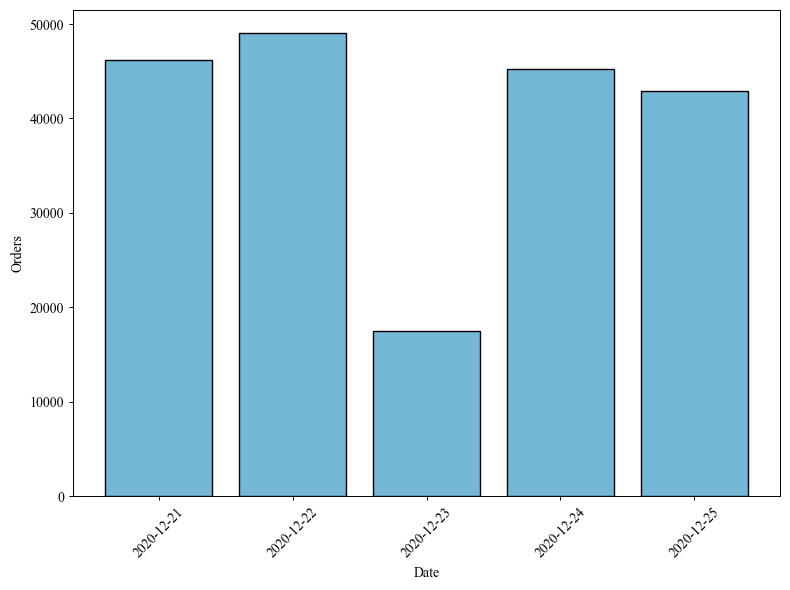

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_16759/549909285.py:37: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')  # Use a subdued style for better clarity


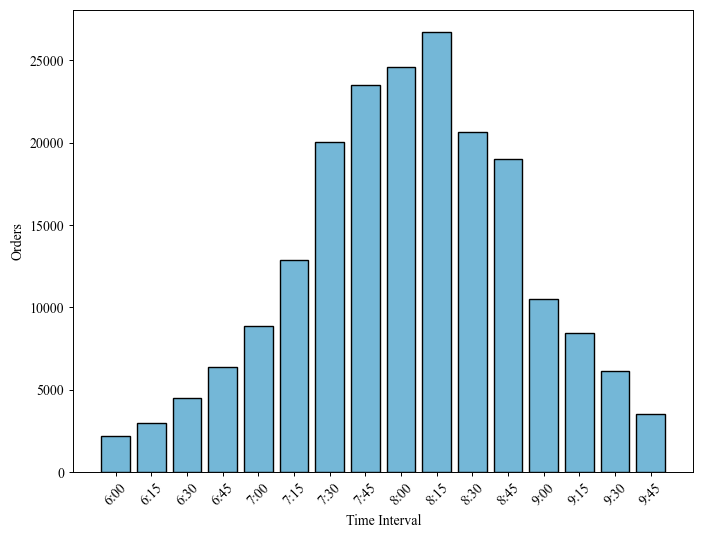

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_16759/549909285.py:56: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')  # Use a subdued style for better clarity


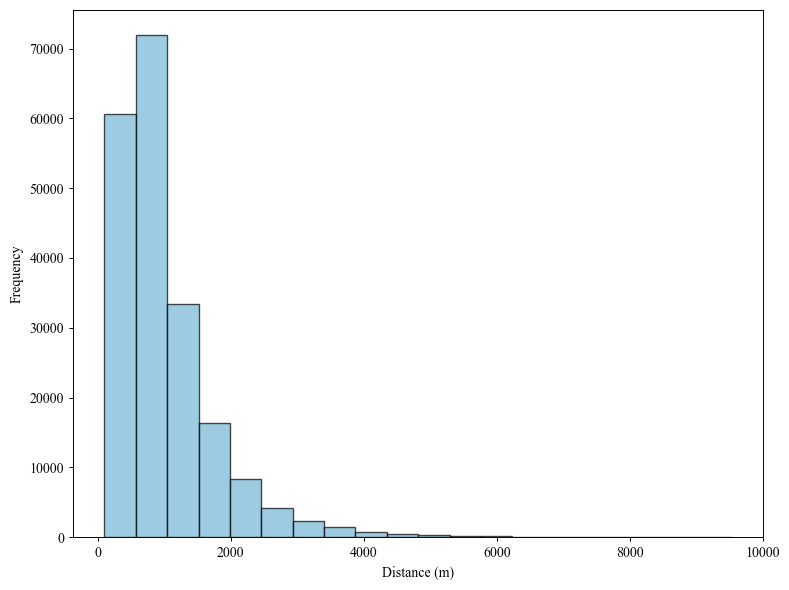

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_16759/549909285.py:70: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')  # Use a subdued style for better clarity


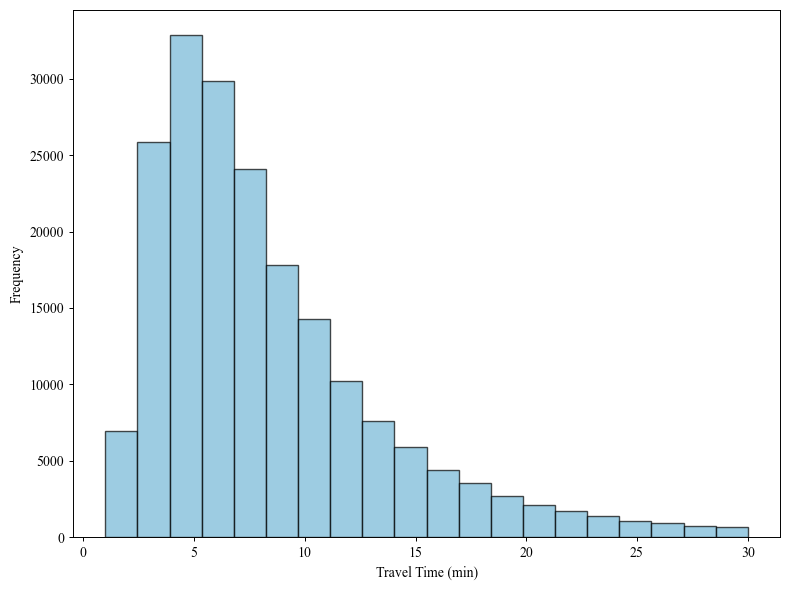

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Set up the style to match SCI standards
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 0.7
plt.rcParams['xtick.major.width'] = 0.7
plt.rcParams['ytick.major.width'] = 0.7
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3

df = move_data.copy()

# Convert date columns to datetime format
df['stime'] = pd.to_datetime(df['stime'])
df['etime'] = pd.to_datetime(df['etime'])

# Plot 1: Bar chart of daily order count with rotated x-axis labels
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-muted')  # Use a subdued style for better clarity
df['date'] = df['stime'].dt.date
daily_order_count = df['date'].value_counts().sort_index()
plt.bar(daily_order_count.index,
        daily_order_count.values,
        color='#74B7D7',  #-----------------改颜色
        edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('/Users/jerseylu/Downloads/bike-sharing/picture/Daily distribution.svg', format='svg')
plt.show()

# Plot 2: Bar chart of order count by time intervals (15-min intervals) with rotated x-axis labels
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-muted')  # Use a subdued style for better clarity
df['hour'] = df['stime'].dt.hour
df['minute'] = df['stime'].dt.minute // 15 * 15  # Calculate 15-min intervals
df['time_interval'] = df.apply(lambda row: f"{row['hour']}:{row['minute']:02d}", axis=1)  # Format with leading zeros
time_interval_order_count = df[df['hour'].between(6, 9)]['time_interval'].value_counts().sort_index()

plt.bar(time_interval_order_count.index,
        time_interval_order_count.values,
        color='#74B7D7',  #-----------------改颜色
        edgecolor='black')
plt.xlabel('Time Interval')
plt.ylabel('Orders')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig('/Users/jerseylu/Downloads/bike-sharing/picture/Temporal distribution.svg', format='svg')
plt.show()


# Plot 3: Histogram of distance frequency
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-muted')  # Use a subdued style for better clarity
plt.hist(df['distance'],
         bins=20,
         color='#74B7D7',  #-----------------改颜色
         alpha=0.7,
         edgecolor='black')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('/Users/jerseylu/Downloads/bike-sharing/picture/Travel distance distribution.svg', format='svg')
plt.show()

# Plot 4: Histogram of travel time frequency
plt.figure(figsize=(8, 6))
plt.style.use('seaborn-muted')  # Use a subdued style for better clarity
df['travel_time'] = (df['etime'] - df['stime']).dt.total_seconds() / 60  # Calculate travel time in minutes
plt.hist(df['travel_time'],
         bins=20,
         range=(1, 30),
         color='#74B7D7',  #-----------------改颜色
         alpha=0.7,
         edgecolor='black')
plt.xlabel('Travel Time (min)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('./Travel time distribution.svg', format='svg')
plt.show()


## 活动模式（空间分析）
探索不同地区的骑行活动模式，找出城市内不同区域的骑行偏好和活跃度
### 共享单车OD订单数据点的空间分布

In [12]:
# 以500米×500米的栅格为最小分析单元，对OD进行栅格集计
# 获取栅格划分参数
bounds = (118.0199, 24.4221, 118.1981, 24.5677)
params = tbd.area_to_params(bounds,accuracy = 500)
#集计OD
od_gdf = tbd.odagg_grid(move_data, params, col=['slon', 'slat', 'elon', 'elat'])
od_gdf.head(5)

SLONCOL  SLATCOL  ELONCOL  ELATCOL  count      SHBLON     SHBLAT  \
17119       36       14       30       11      1  118.197788  24.485052   
5632        18       27       19       30      1  118.108844  24.543508   
12923       27        6       33       14      1  118.153316  24.449080   
5628        18       27       18       29      1  118.108844  24.543508   
5627        18       27       18       28      1  118.108844  24.543508   

           EHBLON     EHBLAT  \
17119  118.168140  24.471563   
5632   118.113785  24.556998   
12923  118.182964  24.485052   
5628   118.108844  24.552502   
5627   118.108844  24.548005   

                                                geometry  
17119  LINESTRING (118.19779 24.48505, 118.16814 24.4...  
5632   LINESTRING (118.10884 24.54351, 118.11379 24.5...  
12923  LINESTRING (118.15332 24.44908, 118.18296 24.4...  
5628   LINESTRING (118.10884 24.54351, 118.10884 24.5...  
5627   LINESTRING (118.10884 24.54351, 118.10884 24.5...

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_25189/2131148442.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  subway_lines = subway_xm.groupby('line')['Lng', 'Lat'].apply(


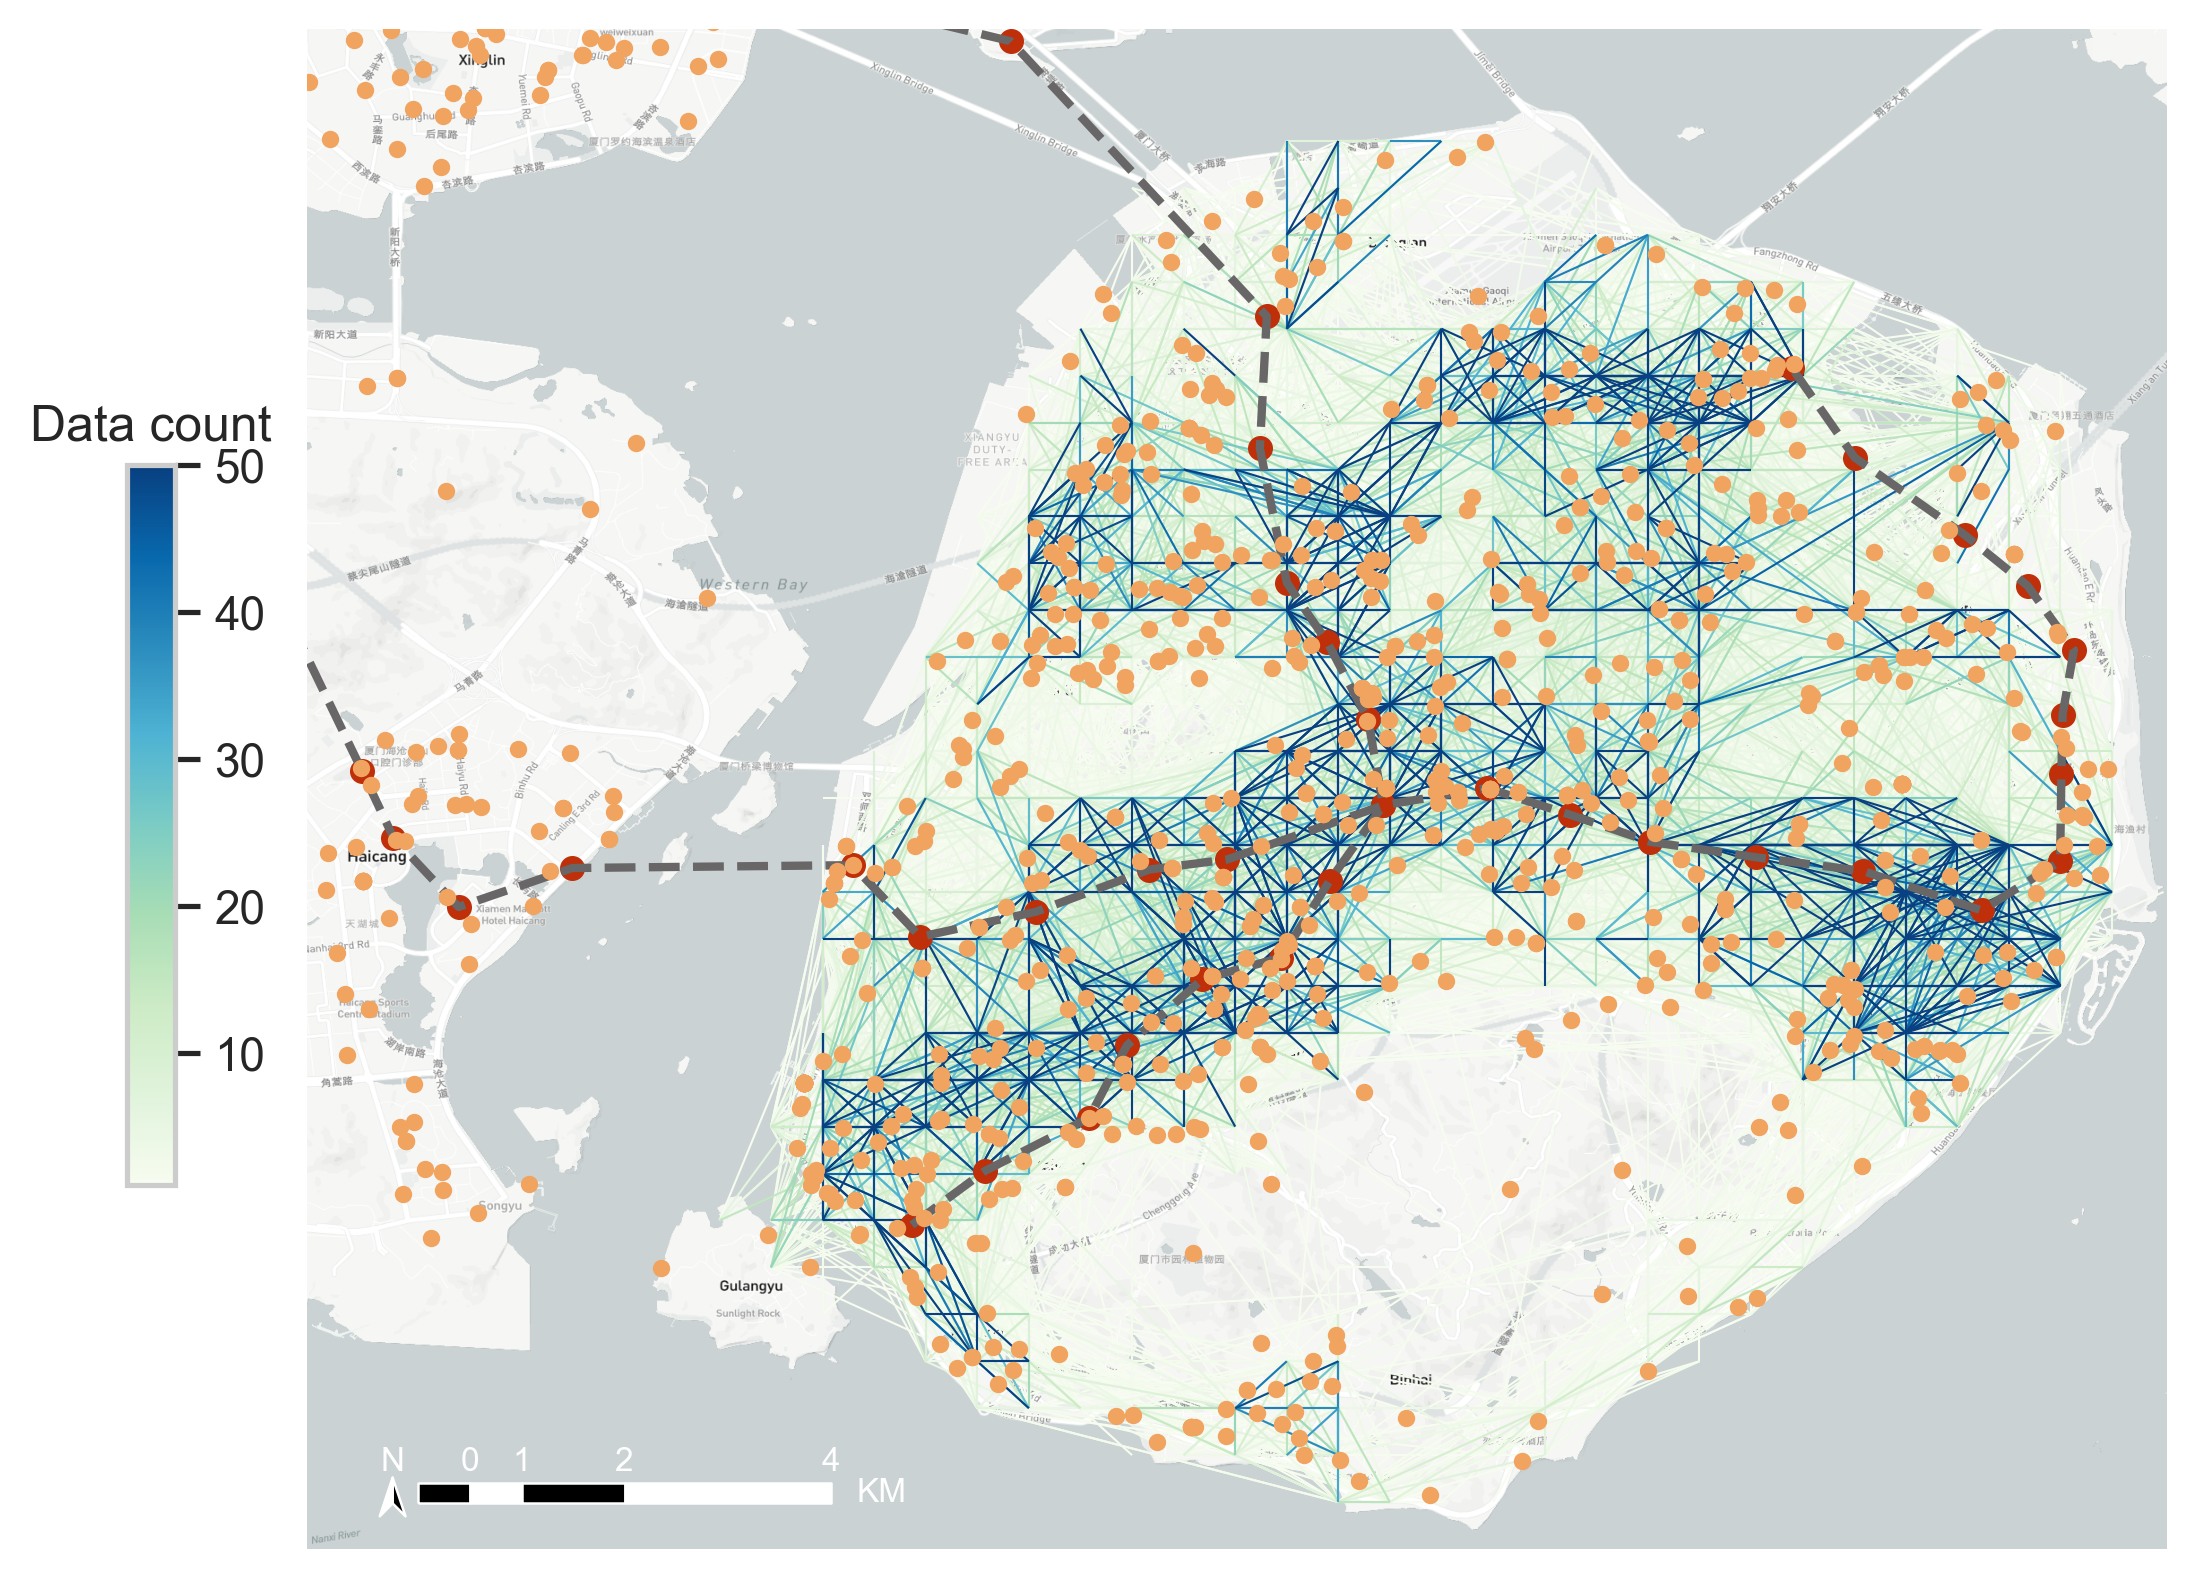

In [20]:
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon, Point
from shapely.geometry import LineString
import matplotlib.pyplot as plt

# 设置Seaborn的绘图风格和配色方案
sns.set(style="whitegrid", palette="colorblind")

# 创建图框
fig = plt.figure(1, (8, 8), dpi=300)
ax = plt.subplot(111)
plt.sca(ax)

# 添加地图底图
tbd.plot_map(plt, bounds, zoom=14, style=4)

# 绘制colorbar
cax = plt.axes([0.05, 0.33, 0.02, 0.3])
plt.title('Data count')
plt.sca(ax)

# Convert bus data to GeoDataFrame
bus_geometry = gpd.points_from_xy(bus_xm['Lng'], bus_xm['Lat'])
gdf_bus_stations = gpd.GeoDataFrame(bus_xm, geometry=bus_geometry)

# 将地铁站点的经纬度数据转换为几何点
subway_geometry = gpd.points_from_xy(subway_xm['Lng'], subway_xm['Lat'])
gdf_subway = gpd.GeoDataFrame(subway_xm, geometry=subway_geometry)

# Group subway stations by line
subway_lines = subway_xm.groupby('line')['Lng', 'Lat'].apply(
    lambda x: x.values.tolist()).to_dict()

# Create LineString geometries for subway lines
line_geometries = []

for line, line_coords in subway_lines.items():
    line_geometry = LineString(line_coords)
    line_geometries.append({'geometry': line_geometry, 'line': line})

# Convert LineString geometries to GeoDataFrame
# gdf_subway_lines = gpd.GeoDataFrame(line_geometries, geometry='geometry', crs=gdf_subway_stations.crs)

# 创建地铁线路和站点的GeoDataFrame
gdf_subway_stations = gpd.GeoDataFrame(subway_xm, geometry=subway_geometry)
gdf_subway_lines = gpd.GeoDataFrame(line_geometries)

# 绘制OD轨迹
od_gdf.plot(ax=ax,
            column='count',
            cmap='GnBu',
            linewidth=0.5,
            vmax=50,
            cax=cax,
            legend=True,
            zorder=1)  # set a lower zorder for the OD trajectory lines

# 绘制地铁线路，使用箭头线样式
gdf_subway_lines.plot(ax=ax,
                      linestyle='dashed',
                      color='#686666',
                      linewidth=2,
                      marker='o',
                      markersize=10)

# 绘制地铁站点
gdf_subway_stations.plot(ax=ax, marker='o', color='#BE2F0A', markersize=25)

# 绘制公交站点
gdf_bus_stations.plot(ax=ax,
                      marker='o',
                      color='#F1A360',
                      markersize=10,
                      zorder=2)  # set a higher zorder for the bus stations

# 添加比例尺和指北针
tbd.plotscale(ax,
              bounds=bounds,
              textsize=8,
              compasssize=0.5,
              textcolor='white',
              accuracy=500,
              rect=[0.06, 0.03],
              zorder=10)

plt.axis('off')
plt.xlim(bounds[0], bounds[2])
plt.ylim(bounds[1], bounds[3])

plt.show()
fig.savefig('./OD_map1.svg', format='svg')

###  不同时间段共享单车出行的空间分布，从上到下分别是出发地、目的地

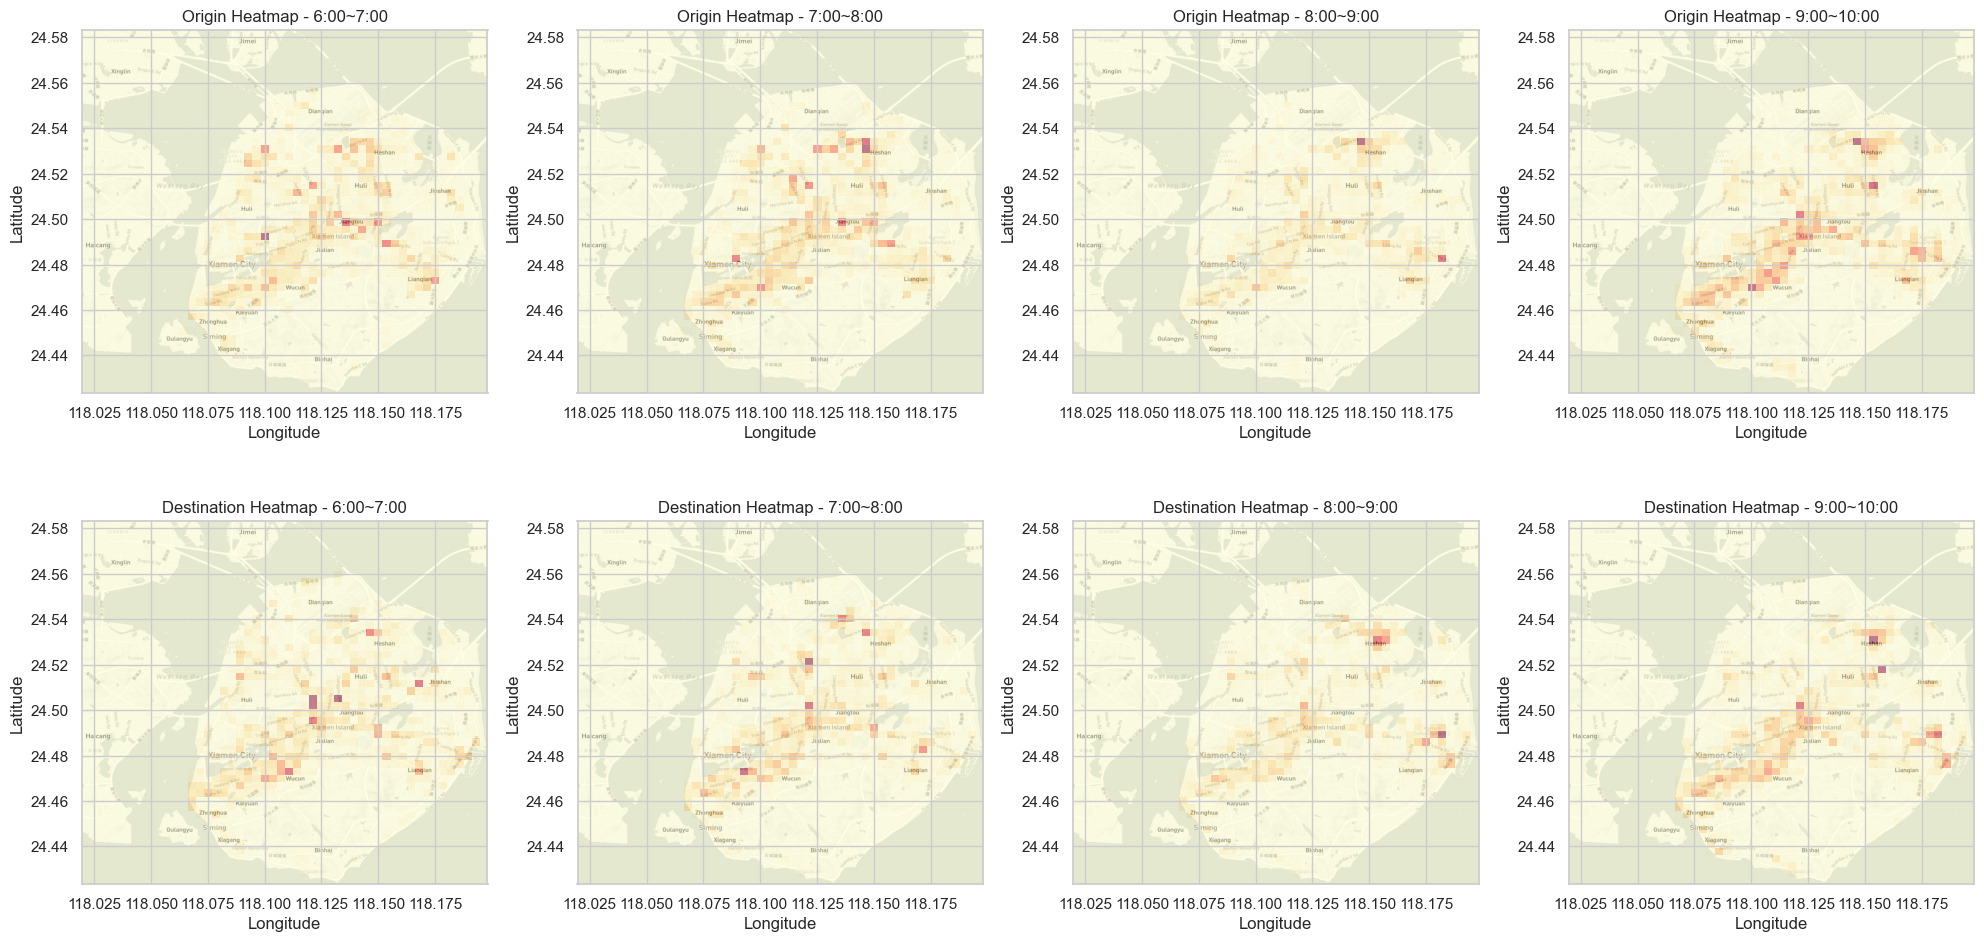

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transbigdata
from transbigdata import plot_map

# Convert datetime columns to datetime objects (replace with your data loading code)
move_data['stime'] = pd.to_datetime(move_data['stime'])
move_data['etime'] = pd.to_datetime(move_data['etime'])

# Define the time ranges
time_ranges = {
    '6:00~7:00': (6, 7),
    '7:00~8:00': (7, 8),
    '8:00~9:00': (8, 9),
    '9:00~10:00': (9, 10)
}

# Filter data within the specified time range
start_time = pd.Timestamp('2020-12-21 06:00:00')
end_time = pd.Timestamp('2020-12-25 10:00:00')
filtered_data = move_data[(move_data['stime'] >= start_time) & (move_data['etime'] <= end_time)]

# Set up subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.subplots_adjust(hspace=0.4)

# Define map bounds and zoom level
bounds = [118.0196, 24.4234, 118.1981, 24.5833]
zoom = 'auto'  # Use 'auto' for automatic zoom level

# Iterate through time ranges and create heatmaps
for i, (time_range, (start_hour, end_hour)) in enumerate(time_ranges.items()):
    row = i // 4
    col = i % 4
    ax_origin = axs[row, col]  # Get the corresponding subplot for origin heatmap
    ax_dest = axs[row + 1, col]  # Get the corresponding subplot for destination heatmap
    
    # Filter data within the current time range
    time_filtered_data = filtered_data[
        (filtered_data['stime'].dt.hour >= start_hour) & (filtered_data['stime'].dt.hour < end_hour)
    ]
    
    # Calculate map bounds based on filtered data
    min_lon = bounds[0]
    max_lon = bounds[2]
    min_lat = bounds[1]
    max_lat = bounds[3]
    
    # Generate origin heatmap data
    origin_heatmap, xedges, yedges = np.histogram2d(
        time_filtered_data['slon'], time_filtered_data['slat'], bins=50,
        range=[[min_lon, max_lon], [min_lat, max_lat]]
    )
    
    # Generate destination heatmap data
    dest_heatmap, xedges, yedges = np.histogram2d(
        time_filtered_data['elon'], time_filtered_data['elat'], bins=50,
        range=[[min_lon, max_lon], [min_lat, max_lat]]
    )
    
    # Plot origin heatmap with map background
    plot_map(ax_origin, bounds, zoom=zoom, style=4)  # Add map background
    ax_origin.imshow(origin_heatmap.T, cmap='YlOrRd', extent=[min_lon, max_lon, min_lat, max_lat], origin='lower', alpha=0.5)
    
    # Plot destination heatmap with map background
    plot_map(ax_dest, bounds, zoom=zoom, style=4)  # Add map background
    ax_dest.imshow(dest_heatmap.T, cmap='YlOrRd', extent=[min_lon, max_lon, min_lat, max_lat], origin='lower', alpha=0.5)

    # Set titles and labels
    ax_origin.set_title(f'Origin Heatmap - {time_range}')
    ax_dest.set_title(f'Destination Heatmap - {time_range}')
    ax_origin.set_xlabel('Longitude')
    ax_origin.set_ylabel('Latitude')
    ax_dest.set_xlabel('Longitude')
    ax_dest.set_ylabel('Latitude')

# Show the plots
plt.tight_layout()

plt.show()


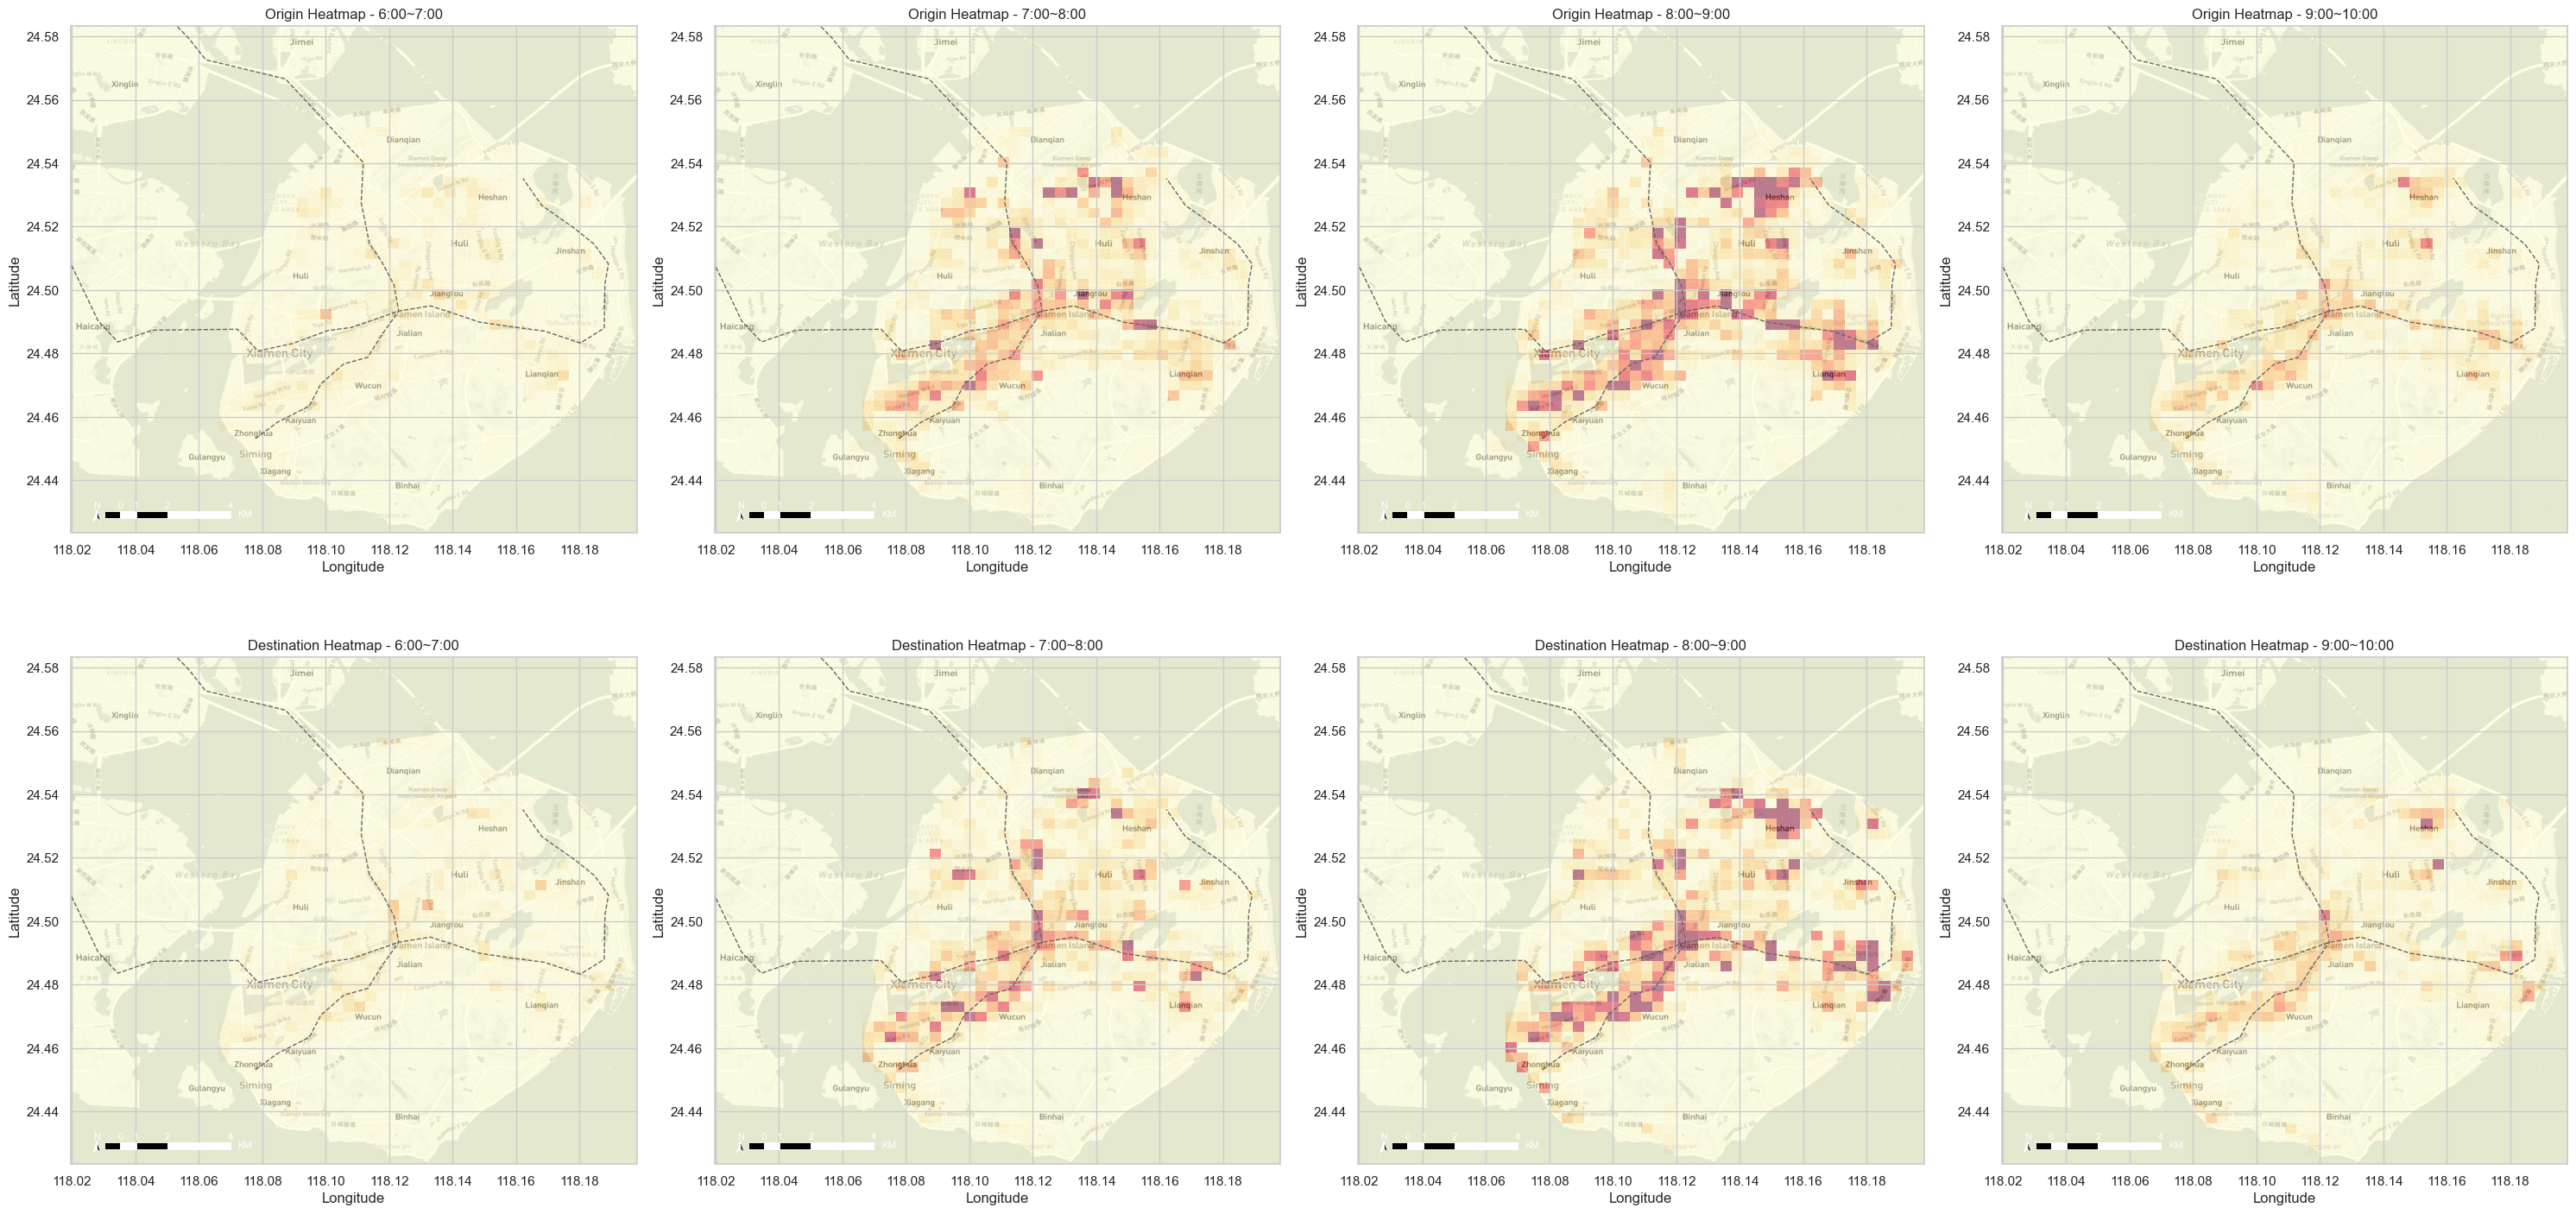

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import transbigdata
from transbigdata import plot_map
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", palette="colorblind", context="notebook")

# Convert datetime columns to datetime objects (replace with your data loading code)
move_data['stime'] = pd.to_datetime(move_data['stime'])
move_data['etime'] = pd.to_datetime(move_data['etime'])

# Define the time ranges
time_ranges = {
    '6:00~7:00': (6, 7),
    '7:00~8:00': (7, 8),
    '8:00~9:00': (8, 9),
    '9:00~10:00': (9, 10)
}

# Filter data within the specified time range
start_time = pd.Timestamp('2020-12-21 06:00:00')
end_time = pd.Timestamp('2020-12-25 10:00:00')
time_filtered_data = move_data[(move_data['stime'] >= start_time) & (move_data['etime'] <= end_time)]

# Normalize the color scale using the maximum value from all heatmaps
max_value = max(np.max(origin_heatmap), np.max(dest_heatmap))
norm = Normalize(vmin=0, vmax=max_value)

# Create a figure with a 2x4 grid layout
fig, axs = plt.subplots(2, 4, figsize=(30, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Iterate through time ranges and create heatmaps
for i, (time_range, (start_hour, end_hour)) in enumerate(time_ranges.items()):
    current_time_filtered_data = time_filtered_data[
        (time_filtered_data['stime'].dt.hour >= start_hour) &
        (time_filtered_data['etime'].dt.hour < end_hour)
    ]

    # Generate origin and destination heatmap data
    origin_heatmap, xedges, yedges = np.histogram2d(
        current_time_filtered_data['slon'], current_time_filtered_data['slat'], bins=50,
        range=[[min_lon, max_lon], [min_lat, max_lat]]
    )
    
    dest_heatmap, xedges, yedges = np.histogram2d(
        current_time_filtered_data['elon'], current_time_filtered_data['elat'], bins=50,
        range=[[min_lon, max_lon], [min_lat, max_lat]]
    )
    
    # Plot subway lines
    gdf_subway_lines.plot(ax=axs[0, i], linestyle='dashed', color='#686666', linewidth=1, marker='o', markersize=10)
    gdf_subway_lines.plot(ax=axs[1, i], linestyle='dashed', color='#686666', linewidth=1, marker='o', markersize=10)

    # Plot origin heatmap with map background
    plot_map(axs[0, i], bounds, zoom=zoom, style=4)
    im1 = axs[0, i].imshow(origin_heatmap.T, cmap='YlOrRd', extent=[min_lon, max_lon, min_lat, max_lat], origin='lower', alpha=0.5, norm=norm)
    axs[0, i].set_title(f'Origin Heatmap - {time_range}')
    axs[0, i].set_xlabel('Longitude')
    axs[0, i].set_ylabel('Latitude')
    axs[0, i].set_xlim(min_lon, max_lon)  # Set x-axis limits
    axs[0, i].set_ylim(min_lat, max_lat)  # Set y-axis limits

    # Plot destination heatmap with map background
    plot_map(axs[1, i], bounds, zoom=zoom, style=4)
    im2 = axs[1, i].imshow(dest_heatmap.T, cmap='YlOrRd', extent=[min_lon, max_lon, min_lat, max_lat], origin='lower', alpha=0.5, norm=norm)
    axs[1, i].set_title(f'Destination Heatmap - {time_range}')
    axs[1, i].set_xlabel('Longitude')
    axs[1, i].set_ylabel('Latitude')
    axs[1, i].set_xlim(min_lon, max_lon)  # Set x-axis limits
    axs[1, i].set_ylim(min_lat, max_lat)  # Set y-axis limits
    
    # Add scale and compass
    tbd.plotscale(ax=axs[0, i], bounds=bounds, textsize=8, compasssize=0.5, textcolor='white', accuracy=500, rect=[0.06, 0.03], zorder=10)
    tbd.plotscale(ax=axs[1, i], bounds=bounds, textsize=8, compasssize=0.5, textcolor='white', accuracy=500, rect=[0.06, 0.03], zorder=10)

# Show the plots and save as SVG
plt.tight_layout()
fig.savefig('./combined_heatmaps.svg', format='svg')
plt.show()


## Human Daily activity recognition
### Distribution of Parking Fence by Main Function(POI)

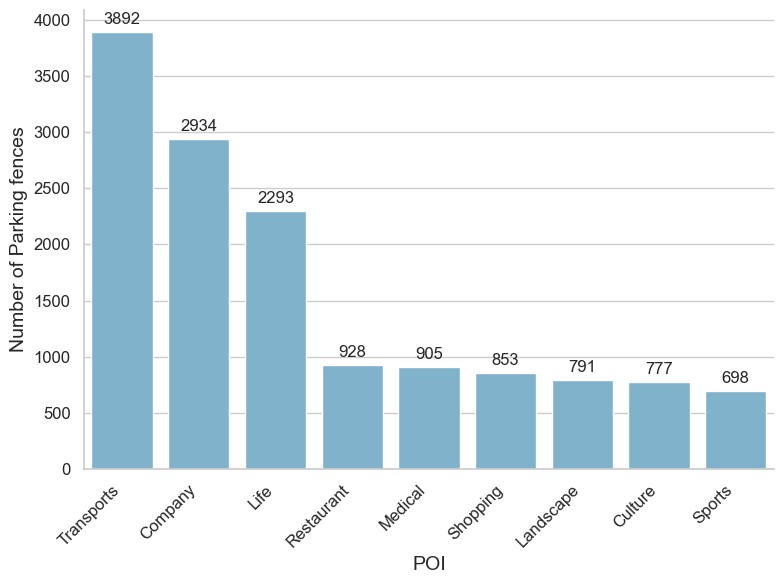

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 统计主要功能数量
main_function_counts = df_fence['poi_type'].value_counts()

# 设置Seaborn样式
sns.set(style="whitegrid")

# 创建柱状图
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=main_function_counts.index,
                       y=main_function_counts.values,
                       color='#74B7D7')

# 设置标题和标签
plt.xlabel("POI", fontsize=14)
plt.ylabel("Number of Parking fences", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

# 去除上方和右侧的边框
sns.despine()

# 在每个柱上显示具体数量
for p in bar_plot.patches:
    bar_plot.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),  # 调整标签的位置
        textcoords='offset points',
        fontsize=12)

# 显示图表
plt.tight_layout()
plt.savefig('./Distribution_POIn.svg', format='svg')
plt.show()

In [21]:
import pandas as pd
from rtree import index

def build_poi_index(POI):
    p = index.Property()
    poi_idx = index.Index(properties=p)
    for idx, poi in POI.iterrows():
        poi_idx.insert(idx, (poi['Lng'], poi['Lat'], poi['Lng'], poi['Lat']))
    return poi_idx

def assign_main_function(poi_idx, lon, lat):
    fence_center = (lon, lat)
    nearest_poi_indices = list(poi_idx.nearest(fence_center, 1))
    if nearest_poi_indices:
        nearest_poi_idx = nearest_poi_indices[0]
        nearest_poi_type = POI.loc[nearest_poi_idx, 'type']
        return nearest_poi_type
    else:
        return None

# 构建R-Tree索引
poi_idx = build_poi_index(POI)

move_data['s_POI'] = move_data.apply(lambda row: assign_main_function(poi_idx, row['slon'], row['slat']), axis=1)
move_data['e_POI'] = move_data.apply(lambda row: assign_main_function(poi_idx, row['elon'], row['elat']), axis=1)


### A chord diagram of the mobility of bike-sharing between different POI types

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
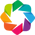

/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_16759/167674337.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  node = pd.DataFrame(link_data['s_POI'].append(link_data['e_POI']).unique(),


In [22]:
import pandas as pd
import numpy as np
import holoviews as hv
from holoviews import opts, dim

hv.extension('bokeh')

# 计算每个连接线的长度（比例）
link_data = move_data.groupby(['s_POI',
                               'e_POI']).size().reset_index(name='count')
link_data['value'] = link_data['count'] / link_data['count'].sum()

# 创建节点和连接线的数据 弦的方向就是 s_POI -> e_POI
node = pd.DataFrame(link_data['s_POI'].append(link_data['e_POI']).unique(),
                    columns=['n'])
nodes = hv.Dataset(
    node,
    'n',
)

chord = hv.Chord((link_data, nodes), ['s_POI', 'e_POI'], ['count'])

# 可选择节点数
busiest = node['n'].to_list()
Chord = chord.select(AirportID=busiest, selection_mode='nodes')

Chord.opts(
    opts.Chord(cmap='Tab20',
               edge_color=dim('s_POI').str(),
               height=500,
               width=500,
               labels='n',
               node_color='n',
               edge_visible=True))

hv.save(Chord, r'./Chord.html')

In [23]:
total_value_per_s_POI = link_data.groupby('s_POI')['value'].sum()
total_value_per_s_POI

s_POI
Company       0.200430
Culture       0.045542
Landscape     0.048958
Life          0.169191
Medical       0.064341
Restaurant    0.064296
Shopping      0.066292
Sports        0.048519
Transports    0.292431
Name: value, dtype: float64

In [24]:
total_value_per_e_POI = link_data.groupby('e_POI')['value'].sum()
total_value_per_e_POI

e_POI
Company       0.270048
Culture       0.038946
Landscape     0.040390
Life          0.151348
Medical       0.063679
Restaurant    0.066636
Shopping      0.065351
Sports        0.051631
Transports    0.251971
Name: value, dtype: float64

### Origin POI and Destination POI

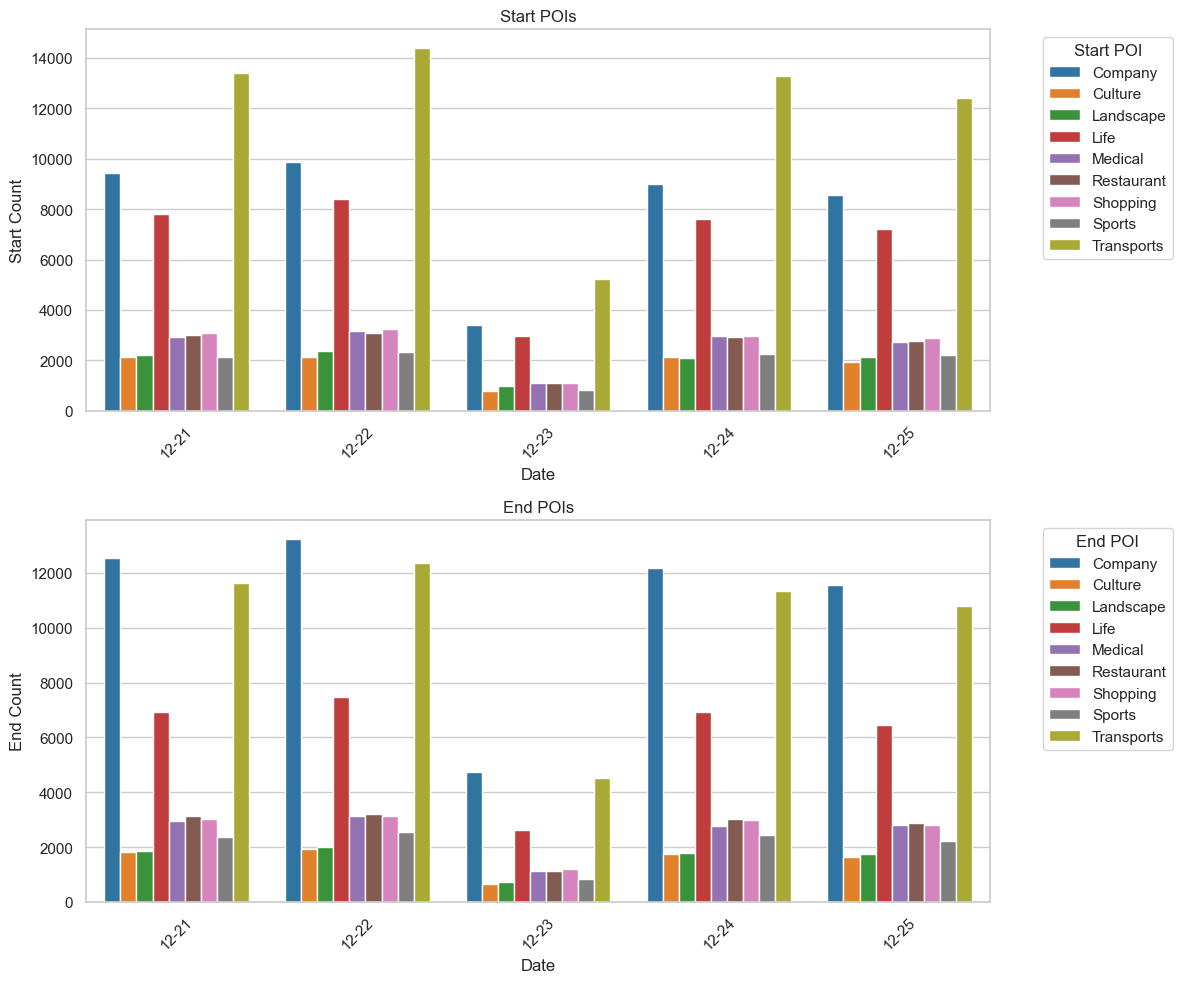

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 将时间列转换为日期格式
move_data['stime'] = pd.to_datetime(move_data['stime'])
move_data['etime'] = pd.to_datetime(move_data['etime'])

# 提取日期信息（月份和日）
move_data['date'] = move_data['stime'].dt.strftime('%m-%d')

# 按日期和起始点 POI 进行分组，并计算每组的数量
start_poi_counts = move_data.groupby(['date', 's_POI']).size().reset_index(name='start_count')

# 按日期和目的地 POI 进行分组，并计算每组的数量
end_poi_counts = move_data.groupby(['date', 'e_POI']).size().reset_index(name='end_count')

# 设置 Seaborn 风格
sns.set(style="whitegrid")
sns.set_palette("tab10")  # 使用 SCI 配色方案

# 创建一个包含两个子图的画布
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# 起始点 POI 子图
sns.barplot(ax=axes[0], x='date', y='start_count', hue='s_POI', data=start_poi_counts)
axes[0].set_title('Start POIs')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Start Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].legend(title='Start POI', bbox_to_anchor=(1.05, 1), loc='upper left')

# 目的地 POI 子图
sns.barplot(ax=axes[1], x='date', y='end_count', hue='e_POI', data=end_poi_counts)
axes[1].set_title('End POIs')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('End Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].legend(title='End POI', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('./POI counts.svg', format='svg')
plt.show()


# BSS Parking Congestion
* 使用经纬度距离匹配的方法来进行尝试，具体的思路为计算订单最近的停车点，进而计算具体的拥挤程度。
* 停车点位拥挤度：C = (还车数量-取车数量)/停车能力，基于停车点位的动态流动和停车能力之间的关系量化拥挤程度
* 由于12-23是中雨天气，共享单车出行受到严重影响，因此在热点的识别与分类中，将2020-12-23全天的数据删除

In [11]:
# 删除2020-12-23这一天的数据
df_order = df_order[df_order['DAY'] != 23]

In [12]:
# 对每个停车点位的使用次数进行集计

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import hnswlib

# 数据预处理
# 拆分 FENCE_CENTER 列
df_fence[['FENCE_CENTER_LAT', 'FENCE_CENTER_LONG']] = pd.DataFrame(df_fence['FENCE_CENTER'].tolist(), index=df_fence.index)

# Nearest Neighbors 模型
knn = NearestNeighbors(metric="haversine", n_jobs=-1, algorithm='ball_tree')
knn.fit(df_fence[['FENCE_CENTER_LAT', 'FENCE_CENTER_LONG']].values)

# 计算最近的停车点
dist, index = knn.kneighbors(df_order[['LATITUDE', 'LONGITUDE']], n_neighbors=1)
df_order['FENCE_ID'] = df_fence.iloc[index.flatten()]['FENCE_ID'].values

# 初始化 HNSWLIB Index
p = hnswlib.Index(space='l2', dim=2)
p.init_index(max_elements=len(df_fence), ef_construction=200, M=48)  # 调整参数
p.set_ef(1024)
p.set_num_threads(14)

# 将停车点坐标添加到 HNSWLIB Index
p.add_items(df_fence[['FENCE_CENTER_LAT', 'FENCE_CENTER_LONG']].values)

df_fence["Count"] = df_fence["FENCE_ID"].map(df_order["FENCE_ID"].value_counts()).fillna(0)

/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


## '5T', '15T', '30T' 时间间隔内的停车点位拥挤程度

In [54]:
import pandas as pd

# 定义时间间隔
time_intervals = ['5T', '15T','60T']

# 创建两个字典来存储每个时间间隔的拥挤度值
df_cong = {}  # 存储拥挤度数据

# 遍历不同的时间间隔
for time_interval in time_intervals:
    # 使用DataFrame的query方法来过滤数据
    inflow_df = df_order.query("LOCK_STATUS == 1")
    outflow_df = df_order.query("LOCK_STATUS == 0")

    # 使用groupby和resample来计算流入和流出
    bike_inflow = inflow_df.groupby(['FENCE_ID', pd.Grouper(key='UPDATE_TIME', freq=time_interval)])['LOCK_STATUS'].count()
    bike_outflow = outflow_df.groupby(['FENCE_ID', pd.Grouper(key='UPDATE_TIME', freq=time_interval)])['LOCK_STATUS'].count()

    # 计算每个时间间隔的拥挤度
    congestion = (bike_inflow - bike_outflow) / (df_fence.set_index('FENCE_ID')['PARKING_CAPACITY'])
    congestion.dropna(inplace=True)
    agg_congestion = congestion.groupby('FENCE_ID').mean()

    # 将拥挤度数据存储在字典中
    df_cong[time_interval] = congestion.reset_index()
    df_cong[time_interval].columns = ['FENCE_ID', 'UPDATE_TIME', 'congestion']
    
    # 提取UPDATE_TIME中的Day，Hour，Min信息
    df_cong[time_interval]['Date'] = df_cong[time_interval]['UPDATE_TIME'].dt.date
    df_cong[time_interval]['Date'] = pd.to_datetime(df_cong[time_interval]['Date'])
    df_cong[time_interval]['Date'] = df_cong[time_interval]['Date'].dt.strftime('%Y-%m-%d')

# 存储不同时间间隔的拥挤度数据
C5 = df_cong['5T'].sort_values('congestion', ascending=False)
C15 = df_cong['15T'].sort_values('congestion', ascending=False)
C60 = df_cong['60T'].sort_values('congestion', ascending=False)

## 早高峰时段的共享单车拥挤度

In [61]:
# 构建早高峰时段的共享单车拥挤程度数据集
from geopy.distance import great_circle

# 计算每个FENCE_ID的congestion平均值
df_aggcong_60 = C60.groupby('FENCE_ID')['congestion'].mean().reset_index()

df_aggcong_60 = df_aggcong_60.merge(df_fence.set_index('FENCE_ID')[['FENCE_LOC', 'PARKING_CAPACITY', 'FENCE_CENTER_LAT', 'FENCE_CENTER_LONG', 'Main_Function', 'Count']],
                              left_on='FENCE_ID', right_index=True)

df_aggcong_60['Count'] = df_aggcong_60['Count'] / 16

df_aggcong_60 = df_aggcong_60.sort_values('congestion', ascending=False)

df_aggcong_60['FENCE_CENTER_LOC'] = df_aggcong_60.apply(lambda row: (row['FENCE_CENTER_LAT'], row['FENCE_CENTER_LONG']), axis=1)

df_aggcong_60

FENCE_ID  congestion  \
4519            望海路0_R_2    9.925000   
8063            象屿路0_R_1    6.736111   
7935  观日路(望海路至会展路段 )_R_1    6.453782   
4518            望海路0_R_1    4.812500   
534           云顶北路0_R_45    3.602564   
...                  ...         ...   
5784           湖滨中路0_L_1   -7.882353   
4711     枋湖北二路0_L_A21001   -8.690000   
2731  吕岭路(洪文路至云顶中路段)_R_1  -10.525000   
7941       观日路0_R_A07001  -11.000000   
8453       金山路0_R_A04005  -12.812500   

                                              FENCE_LOC  PARKING_CAPACITY  \
4519  [[118.179600502, 24.4916542622], [118.17958991...               5.0   
8063  [[118.088508795, 24.5137777608], [118.08849974...               4.0   
7935  [[118.1811945889, 24.4881023165], [118.1811646...               7.0   
4518  [[118.181675856, 24.4898229298], [118.18159669...               7.0   
534   [[118.146595443, 24.5377544107], [118.14657921...               6.0   
...                                                 ...               ...   
5784  [[118.098397204, 24.470384998], [118.098381288...               6.0   
4711  [[118.146861, 24.524686], [118.146906, 24.5246...               5.0   
2731  [[118.1547049975, 24.4885525418], [118.1546105...               8.0   
7941  [[118.188446, 24.487203], [118.188416, 24.4872...               3.0   
8453  [[118.1699352, 24.489668], [118.1699299, 24.48...               4.0   

      FENCE_CENTER_LAT  FENCE_CENTER_LONG Main_Function     Count  \
4519         24.491660         118.179580    Commercial   31.6875   
8063         24.513762         118.088496    Commercial   44.1875   
7935         24.488079         118.181172    Commercial  140.6875   
4518         24.489823         118.181635    Commercial   77.0625   
534          24.537778         118.146577   Residential   51.9375   
...                ...                ...           ...       ...   
5784         24.470409         118.098381    Commercial   59.6875   
4711         24.524684         118.146886    Commercial   76.0625   
2731         24.488563         118.154658    Recreation  146.6250   
7941         24.487213         118.188433    Commercial    3.3750   
8453         24.489650         118.169924    Commercial   37.8750   

                              FENCE_CENTER_LOC  
4519         (24.49165950575, 118.17957954625)  
8063        (24.513762239325, 118.08849559525)  
7935      (24.488079166250003, 118.1811723746)  
4518     (24.489822827774997, 118.18163499575)  
534       (24.53777771855, 118.14657666899998)  
...                                        ...  
5784        (24.470408632025, 118.09838054225)  
4711          (24.524683999999997, 118.146886)  
2731     (24.488562640650002, 118.15465829085)  
7941        (24.487212749999998, 118.18843275)  
8453  (24.489649500000002, 118.16992429999999)  

[9759 rows x 9 columns]

In [65]:
df_fence = df_fence.merge(df_aggcong_60.set_index('FENCE_ID')[['congestion']],
                              left_on='FENCE_ID', right_index=True).fillna(0)

In [78]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric="haversine", n_jobs=-1, algorithm='brute')
knn.fit(np.stack(df_fence['FENCE_CENTER'].values))

def fence_recommend1(fence_id):
    '''
    乘客到了一个潮汐停车点A：
    1. 推荐的停车点B应该和A距离不远；
    2. 推荐的停车点B应该没有潮汐情况；
    3. 也需要考虑到跨街道和横穿马路的情况；
    '''
    fence_center = df_fence.loc[df_fence['FENCE_ID'] == fence_id, 'FENCE_CENTER'].values[0]
    # 具体街道方向
    fence_dir = fence_id.split('_')[1]
    # 根据距离计算最近的10个待选位置
    dist, index = knn.kneighbors([fence_center], n_neighbors=10)

    # 保存推荐结果的列表
    recommendations = []

    # 对每个待选位置进行筛选
    for idx in index[0]:
        # 剔除已经有很多车的
        if df_fence.iloc[idx]['congestion'] > 1:
            continue
        # 剔除需要过街的
        if fence_dir not in df_fence.iloc[idx]['FENCE_ID']:
            continue
        # 计算推荐停车点距离的距离
        distance = geodesic(fence_center, df_fence.iloc[idx]['FENCE_CENTER']).meters
        recommendations.append({'FENCE_ID': df_fence.iloc[idx]['FENCE_ID'], 'Distance': distance})

    return recommendations

def fence_recommend2(la, lo):
    '''
    单车还没到停车点的情况，即推荐根据经纬度推荐最近非潮汐停车点
    '''
    dist, index = knn.kneighbors([[la, lo]], n_neighbors=20)

    # 保存推荐结果的列表
    recommendations = []

    for idx in index[0][1:]:
        # 剔除已经有很多车的
        if df_fence.iloc[idx]['congestion'] > 1:
            continue
        # 计算推荐停车点距离的距离
        distance = geodesic([la, lo], df_fence.iloc[idx]['FENCE_CENTER']).meters
        recommendations.append({'FENCE_ID': df_fence.iloc[idx]['FENCE_ID'], 'Distance': distance})

    return recommendations


In [79]:
# 调用 fence_recommend1，传入一个潮汐停车点的 fence_id
fence_id_1 = '望海路0_R_2'  # 你的实际停车点ID
recommended_fence_1 = fence_recommend1(fence_id_1)
print(f"Recommended Fence ID based on Tide Conditions: {recommended_fence_1}")

# 调用 fence_recommend2，传入未到达停车点的位置的纬度和经度
latitude = 24.475794
longitude = 118.118226
recommended_fence_2 = fence_recommend2(latitude, longitude)
print(f"Recommended Fence ID based on Location: {recommended_fence_2}")


Recommended Fence ID based on Tide Conditions: [{'FENCE_ID': '环岛干道0_R_A06011', 'Distance': 406.45031749965}, {'FENCE_ID': '会展路(吕岭路至塔埔路段)_R_7', 'Distance': 409.0542081090248}]
Recommended Fence ID based on Location: [{'FENCE_ID': '东浦路_L_10', 'Distance': 191.08017228106115}, {'FENCE_ID': '东浦路_L_12', 'Distance': 183.3236991165712}, {'FENCE_ID': '东浦路_R_4', 'Distance': 189.33967848871805}, {'FENCE_ID': '东浦路0_L_1', 'Distance': 199.88310416205965}, {'FENCE_ID': '东浦路0_R_4', 'Distance': 189.02242243379408}, {'FENCE_ID': '东浦路_R_5', 'Distance': 202.56450921592906}, {'FENCE_ID': '东浦路_R_A04001', 'Distance': 194.18939569217946}, {'FENCE_ID': '东浦路_L_A04001', 'Distance': 215.96656728634355}, {'FENCE_ID': '东浦路0_R_3', 'Distance': 200.3968137753535}, {'FENCE_ID': '东浦路0_L_3', 'Distance': 219.6782994682618}, {'FENCE_ID': '坂尾路_L_1', 'Distance': 232.8967677056329}, {'FENCE_ID': '东浦路_L_13', 'Distance': 206.6997903006852}, {'FENCE_ID': '东浦路0_R_2', 'Distance': 222.4743791917393}, {'FENCE_ID': '东浦路_R_2_A', 'Dist

## 拥堵点位聚类分析

/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt

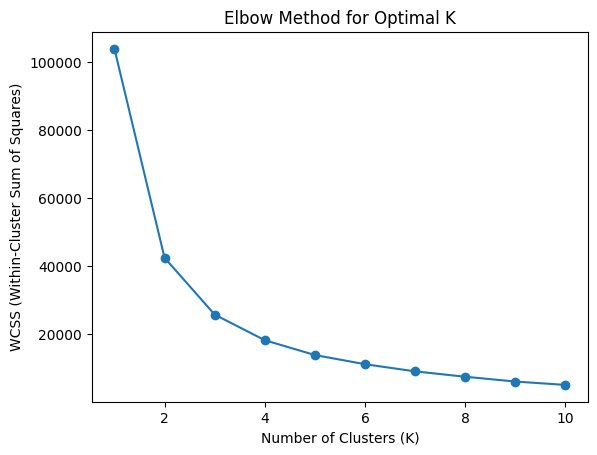

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 提取特征
features = ['congestion', 'PARKING_CAPACITY', 'Count','POI_index']
X = df_aggcong_60[features]

# 计算不同K值对应的WCSS
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# 绘制肘部法则图
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()


/opt/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k-means Silhouette Score:  0.6365694159287947
GMM Silhouette Score:  0.4284032907221669


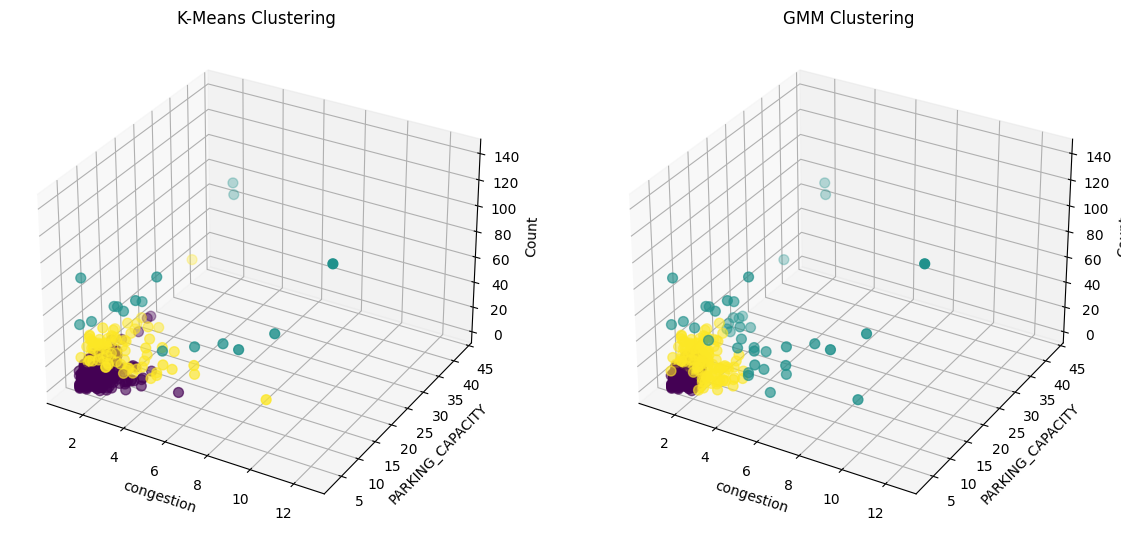

In [25]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 提取特征
features = ['congestion', 'PARKING_CAPACITY', 'Count','POI_index']
X = df_aggcong_60[features]

# 根据肘部法则，选择最佳的 K 值
best_k = 3

# 使用k-means算法进行聚类
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_silhouette_score = silhouette_score(X, kmeans_labels)

# 使用GMM算法进行聚类
gmm = GaussianMixture(n_components=best_k, random_state=42)
gmm_labels = gmm.fit_predict(X)
gmm_silhouette_score = silhouette_score(X, gmm_labels)

# 输出轮廓系数
print("k-means Silhouette Score: ", kmeans_silhouette_score)
print("GMM Silhouette Score: ", gmm_silhouette_score)

# 绘制3D散点图
fig = plt.figure(figsize=(14, 8))

# K-Means Clustering
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X['congestion'], X['PARKING_CAPACITY'], X['Count'], c=kmeans_labels, cmap='viridis', s=50)
ax1.set_xlabel('congestion')
ax1.set_ylabel('PARKING_CAPACITY')
ax1.set_zlabel('Count')
ax1.set_title('K-Means Clustering')

# GMM Clustering
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X['congestion'], X['PARKING_CAPACITY'], X['Count'], c=gmm_labels, cmap='viridis', s=50)
ax2.set_xlabel('congestion')
ax2.set_ylabel('PARKING_CAPACITY')
ax2.set_zlabel('Count')
ax2.set_title('GMM Clustering')

plt.savefig('./clustering.svg', format='svg')
plt.show()


In [21]:
df_aggcong_60['KMeans_Cluster'] = kmeans_labels
df_aggcong_60['KMeans_Cluster'].value_counts()

0    460
2     86
1     17
Name: KMeans_Cluster, dtype: int64

In [22]:
df_aggcong_60[df_aggcong_60['KMeans_Cluster'] == 0].describe()

congestion  PARKING_CAPACITY  FENCE_CENTER_LAT  FENCE_CENTER_LONG  \
count  460.000000        460.000000        460.000000         460.000000   
mean     1.631699          5.873913         24.495764         118.127089   
std      0.542753          2.246608          0.025578           0.032731   
min      1.076923          3.000000         24.428582         118.067230   
25%      1.250000          4.000000         24.476040         118.100908   
50%      1.500000          5.000000         24.491616         118.123462   
75%      1.800000          7.000000         24.518022         118.154391   
max      5.800000         23.000000         24.557759         118.192397   

            Count  Count_Other  Count_Commercial  Count_Recreation  \
count  460.000000   460.000000        460.000000        460.000000   
mean     7.588587     1.360870         15.739130          2.991304   
std      3.619187     7.285359         15.976064          8.605613   
min      1.125000     0.000000          0.000000          0.000000   
25%      4.625000     0.000000          0.000000          0.000000   
50%      6.812500     0.000000         14.000000          0.000000   
75%      9.937500     0.000000         24.250000          0.000000   
max     16.437500    80.000000         69.000000         66.000000   

       Count_Residential   Bus_Count   POI_index  KMeans_Cluster  
count         460.000000  460.000000  460.000000           460.0  
mean            3.934783    0.402174    0.004005             0.0  
std            11.823506    0.833134    0.002463             0.0  
min             0.000000    0.000000    0.000000             0.0  
25%             0.000000    0.000000    0.002334             0.0  
50%             0.000000    0.000000    0.003334             0.0  
75%             0.000000    1.000000    0.005001             0.0  
max            68.000000    7.000000    0.013336             0.0

In [23]:
df_aggcong_60[df_aggcong_60['KMeans_Cluster'] == 1].describe()

congestion  PARKING_CAPACITY  FENCE_CENTER_LAT  FENCE_CENTER_LONG  \
count   17.000000         17.000000         17.000000          17.000000   
mean     4.535738         10.764706         24.497036         118.146692   
std      3.413173         12.132237          0.019673           0.031395   
min      1.200000          3.000000         24.474252         118.089485   
25%      2.172619          5.000000         24.487116         118.128688   
50%      2.857143          7.000000         24.488961         118.148462   
75%      6.425926          8.000000         24.495210         118.176598   
max     12.547619         43.000000         24.537778         118.181635   

            Count  Count_Other  Count_Commercial  Count_Recreation  \
count   17.000000         17.0         17.000000         17.000000   
mean    68.176471          0.0         17.941176          1.470588   
std     22.250003          0.0         13.516058          6.063391   
min     47.750000          0.0          0.000000          0.000000   
25%     54.750000          0.0         14.000000          0.000000   
50%     59.375000          0.0         17.000000          0.000000   
75%     74.562500          0.0         18.000000          0.000000   
max    140.687500          0.0         59.000000         25.000000   

       Count_Residential  Bus_Count  POI_index  KMeans_Cluster  
count          17.000000  17.000000  17.000000            17.0  
mean            0.058824   0.294118   0.003246             1.0  
std             0.242536   0.587868   0.002115             0.0  
min             0.000000   0.000000   0.000167             1.0  
25%             0.000000   0.000000   0.002334             1.0  
50%             0.000000   0.000000   0.002834             1.0  
75%             0.000000   0.000000   0.003667             1.0  
max             1.000000   2.000000   0.009835             1.0

In [24]:
df_aggcong_60[df_aggcong_60['KMeans_Cluster'] == 2].describe()

congestion  PARKING_CAPACITY  FENCE_CENTER_LAT  FENCE_CENTER_LONG  \
count   86.000000         86.000000         86.000000          86.000000   
mean     2.496667          7.883721         24.500728         118.139762   
std      1.474311          4.398980          0.022819           0.031645   
min      1.071429          3.000000         24.439999         118.071212   
25%      1.513889          5.000000         24.483973         118.117846   
50%      1.983333          7.000000         24.493394         118.147536   
75%      3.045357          9.000000         24.519450         118.168291   
max      9.925000         35.000000         24.539451         118.188442   

           Count  Count_Other  Count_Commercial  Count_Recreation  \
count  86.000000    86.000000         86.000000         86.000000   
mean   25.105378     1.034884         10.348837          2.674419   
std     7.694806     7.577750         12.944922          6.834931   
min    15.375000     0.000000          0.000000          0.000000   
25%    19.015625     0.000000          0.000000          0.000000   
50%    22.406250     0.000000          4.500000          0.000000   
75%    29.984375     0.000000         18.000000          0.000000   
max    44.687500    67.000000         65.000000         32.000000   

       Count_Residential  Bus_Count  POI_index  KMeans_Cluster  
count          86.000000  86.000000  86.000000            86.0  
mean            5.837209   0.430233   0.003316             2.0  
std            12.905868   0.964557   0.002291             0.0  
min             0.000000   0.000000   0.000333             2.0  
25%             0.000000   0.000000   0.001834             2.0  
50%             0.000000   0.000000   0.003001             2.0  
75%             0.000000   1.000000   0.004001             2.0  
max            74.000000   7.000000   0.012335             2.0

In [46]:
def assign_category(row):
    if row['KMeans_Cluster'] == 0:
        return 'Light-crowded'
    elif row['KMeans_Cluster'] == 1:
        return 'Over-crowded'
    else:
        return 'Semi-crowded'

# 输出结果
df_aggcong_60['Category'] = df_aggcong_60.apply(assign_category, axis=1)
df_aggcong_60.to_csv('./df_aggcong_60.csv', encoding='utf-8')

In [47]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point
from shapely.geometry import LineString
from keplergl import KeplerGl
import json
import numpy as np

# Convert data to GeoDataFrame
geometry = [Polygon(coords) for coords in df_aggcong_60['FENCE_LOC']]
gdf_TI = gpd.GeoDataFrame(df_aggcong_60, geometry=geometry)

# Convert NumPy arrays to lists for JSON serialization
gdf_TI['FENCE_LOC'] = gdf_TI['FENCE_LOC'].apply(lambda x: x.tolist())

# Convert subway data to GeoDataFrame
subway_geometry = gpd.points_from_xy(subway_xm['Lng'], subway_xm['Lat'])
gdf_subway_stations = gpd.GeoDataFrame(subway_xm, geometry=subway_geometry)

# Convert bus data to GeoDataFrame
bus_geometry = gpd.points_from_xy(bus_xm['Lng'], bus_xm['Lat'])
gdf_bus_stations = gpd.GeoDataFrame(bus_xm, geometry=bus_geometry)

# Group subway stations by line
subway_lines = subway_xm.groupby('line')['Lng', 'Lat'].apply(
    lambda x: x.values.tolist()).to_dict()

# Create LineString geometries for subway lines
line_geometries = []

for line, line_coords in subway_lines.items():
    line_geometry = LineString(line_coords)
    line_geometries.append({'geometry': line_geometry, 'line': line})

# Convert LineString geometries to GeoDataFrame
gdf_subway_lines = gpd.GeoDataFrame(line_geometries,
                                    geometry='geometry',
                                    crs=gdf_subway_stations.crs)

# Create Kepler map
map_1 = KeplerGl(height=800)

# Add GeoDataFrame of subway and bus data to the map
map_1.add_data(data=gdf_subway_stations, name='Subway Stations')
map_1.add_data(data=gdf_bus_stations, name='Bus Stations')
map_1.add_data(data=gdf_subway_lines, name='Subway Lines')

cluster_categories = ['Over-crowded', 'Semi-crowded', 'Light-crowded']

# Loop through each color category and add corresponding TI data to the map
for cluster_category in cluster_categories:
    TI_data = gdf_TI[gdf_TI['Category'] == cluster_category].copy()
    TI_data['Category'] = cluster_category

    # Add data to the existing KeplerGl map (map_1)
    map_1.add_data(data=TI_data, name='TI ' + cluster_category.capitalize())

# Display the map
map_1
# map_1.save_to_html(file_name='./picture/hotspots_map.html')

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/var/folders/sg/4tbtggb55k590h6qc67thpgr0000gn/T/ipykernel_16759/2732664643.py:25: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  subway_lines = subway_xm.groupby('line')['Lng', 'Lat'].apply(


KeplerGl(data={'Subway Stations': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…

In [49]:
map_1.save_to_html(file_name='./crowd_map1.html') 

Map saved to ./crowd_map1.html!
